In [1]:
%load_ext memory_profiler
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client, LocalCluster, wait
from itertools import chain
from pathlib import Path
from glob import glob
import xarray as xr

In [4]:
from xorca.lib import load_xorca_dataset
from xorca.calc import calculate_speed, calculate_psi, calculate_moc

In [5]:
# Start a local cluster with 4 2-threaded workers which get
# 4 GiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [6]:
client

Client Scheduler: tcp://127.0.0.1:34076 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


In [7]:
data_path = Path("../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/")
data_files = list(sorted(data_path.glob("ORCA025*nc")))
aux_files = list(sorted(data_path.glob("[m, n]*nc")))

In [8]:
print(aux_files)
print(data_files)

[PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/mask.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/mesh_hgr.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/mesh_zgr.nc')]
[PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002_1m_19800101_19801231_grid_T.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002_1m_19800101_19801231_grid_U.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002_1m_19800101_19801231_grid_V.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002_1m_19800101_19801231_icemod.nc'), PosixPath('../../xorca-example-data/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002/ORCA025.L46.LIM2vp.JRA.XIOS2.KMS-T002_1m_19810101_19811231_grid_T.nc'), Posix

In [9]:
%%time
%%memit
ds_xorca = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True,
                              input_ds_chunks={"time_counter": 6, "t": 6,
                                               "z": 23, "Z": 23,
                                               "deptht": 23, "depthu": 23,
                                               "depthv": 23, "depthw": 23,
                                               "y": 511, "Y": 511,
                                               "x": 361, "X": 361},
                              target_ds_chunks={"t": 6,
                                                "z_c": 23, "z_l": 23,
                                                "y_c": 511, "y_r": 511,
                                                "x_c": 360, "x_r": 360})

peak memory: 393.71 MiB, increment: 272.39 MiB
CPU times: user 13.3 s, sys: 1.71 s, total: 15 s
Wall time: 18.9 s


In [10]:
print(ds_xorca)

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 1440, x_r: 1440, y_c: 1019, y_r: 1019, z_c: 46, z_l: 46)
Coordinates:
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llat_cc   (y_c, x_c) float32 dask.array<shape=(1019, 1440), chunksize=(511, 360)>
    llat_rr   (y_r, x_r) float32 dask.array<shape=(1019, 1440), chunksize=(511, 360)>
    llon_cc   (y_c, x_c) float32 dask.array<shape=(1019, 1440), chunksize=(511, 360)>
    llat_rc   (y_r, x_c) float32 dask.array<shape=(1019, 1440), chunksize=(511, 360)>
    depth_c   (z_c) float64 dask.array<shape=(46,), chunksize=(23,

In [11]:
print(ds_xorca.nbytes / 1e9, "GiB")
print(ds_xorca.vomecrty.nbytes / 1e9, "GiB")
print(ds_xorca.vozocrtx.nbytes / 1e9, "GiB")

45.370812208 GiB
6.47986176 GiB
6.47986176 GiB


In [12]:
%%time
for vn in ["vomecrty", "vozocrtx"]:
    ds_xorca[vn] = ds_xorca[vn].persist()
f = wait(ds_xorca);

CPU times: user 37 s, sys: 2.33 s, total: 39.4 s
Wall time: 2min 17s


In [13]:
%%time
%memit psi_mean = calculate_psi(ds_xorca).mean("t").compute()

peak memory: 374.46 MiB, increment: 19.04 MiB
CPU times: user 5.02 s, sys: 342 ms, total: 5.36 s
Wall time: 7.16 s


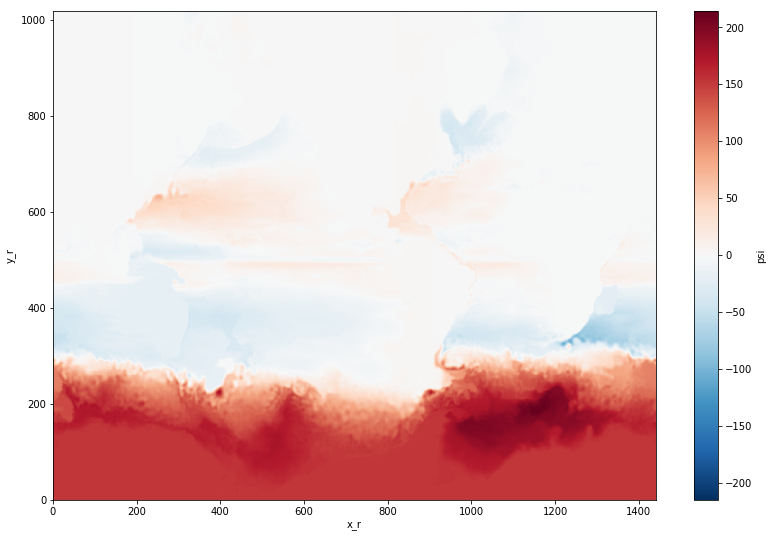

In [14]:
psi_mean.plot(size=9);

In [15]:
%%time
%memit speed_max = calculate_speed(ds_xorca).max(dim=["t", "z_c"]).compute()

peak memory: 403.07 MiB, increment: 3.65 MiB
CPU times: user 6.5 s, sys: 423 ms, total: 6.92 s
Wall time: 11.9 s


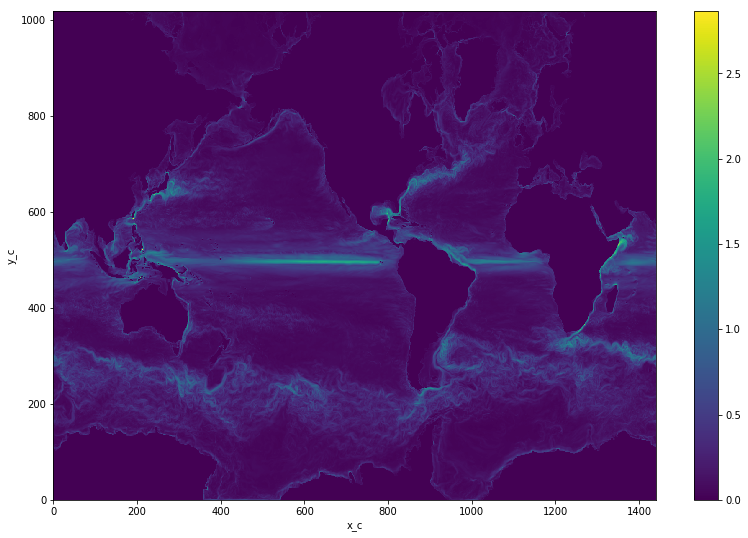

In [16]:
speed_max.plot(size=9);

In [17]:
%%time
%memit moc_mean = calculate_moc(ds_xorca, region="").mean("t").compute()

peak memory: 411.58 MiB, increment: 11.10 MiB
CPU times: user 11.4 s, sys: 683 ms, total: 12.1 s
Wall time: 18.2 s


In [18]:
%time
%memit moc_std = calculate_moc(ds_xorca, region="").std("t").compute();

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
peak memory: 421.32 MiB, increment: 9.93 MiB


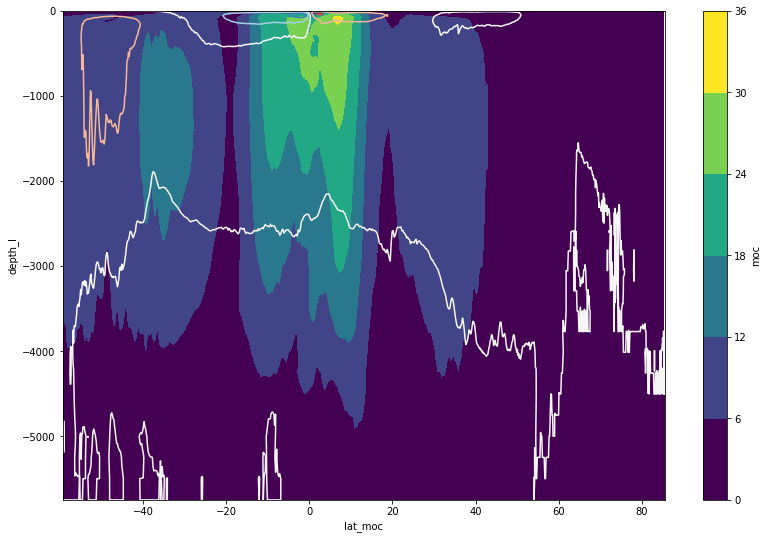

In [19]:
moc_std.sortby("lat_moc").isel(y_r=slice(200, None)).plot.contourf("lat_moc", "depth_l", size=9);
moc_mean.sortby("lat_moc").isel(y_r=slice(200, None)).plot.contour("lat_moc", "depth_l");